Found 2510 images belonging to 2 classes.
Found 626 images belonging to 2 classes.
Epoch 1/30
157/157 [==============================] - 41s 218ms/step - loss: 2.0721 - accuracy: 0.9311 - auc: 0.9388 - val_loss: 0.4147 - val_accuracy: 0.9840 - val_auc: 0.9862 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 33s 213ms/step - loss: 0.9932 - accuracy: 0.9602 - auc: 0.9660 - val_loss: 0.1710 - val_accuracy: 0.9920 - val_auc: 0.9923 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 33s 210ms/step - loss: 0.4147 - accuracy: 0.9709 - auc: 0.9779 - val_loss: 0.1529 - val_accuracy: 0.9904 - val_auc: 0.9923 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 33s 212ms/step - loss: 0.2180 - accuracy: 0.9757 - auc: 0.9849 - val_loss: 0.0814 - val_accuracy: 0.9856 - val_auc: 0.9947 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 32s 207ms/step - loss: 0.1255 - accuracy: 0.9801 - auc: 0.9914 - val_loss: 0.0588 - val_accuracy: 0.987

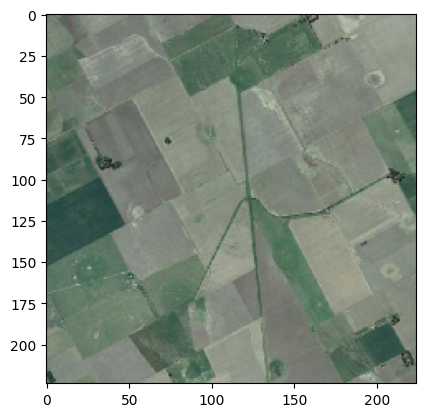

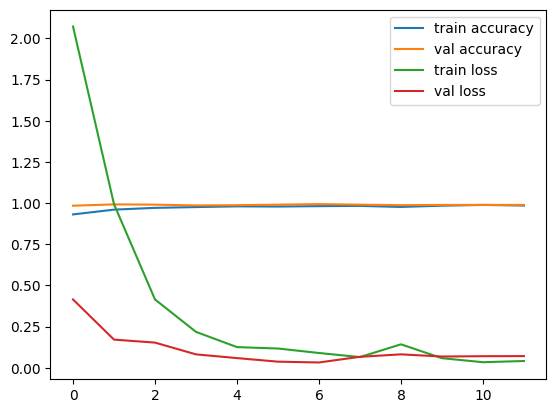

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

# Configure TensorFlow to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set up data generators for train and test data with data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        classes=['construction', 'non_construction'])

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        classes=['construction', 'non_construction'])

# Construct CNN architecture with VGG19 pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=30,
                    validation_data=test_generator,
                    validation_steps=len(test_generator),
                    callbacks=[early_stopping, reduce_lr])

model.save('vgg19.h5')



In [ ]:
import matplotlib.pyplot as plt

# Load the image
img = load_img('test1.jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = preprocess_input(img_array)
img_array = img_array.reshape((1, 224, 224, 3))

# Make a prediction
prediction = model.predict(img_array)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Print the selected class
if prediction < 0.5:
    print("The image is predicted to be", class_labels[0])
else:
    print("The image is predicted to be", class_labels[1])

# Display the image
plt.imshow(img)
plt.show()

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg19.png')
plt.show()

40/40 [==============================] - 4s 104ms/step
Confusion Matrix
[[176 159]
 [161 130]]


NameError: name 'np' is not defined

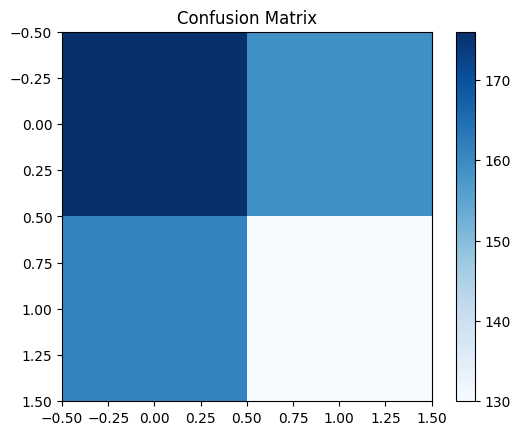

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the predicted classes for the test data
y_pred = model.predict(test_generator).round()

# Get the true classes for the test data
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()